In [19]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import Vocaburary, TextGCN

import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure

from IPython.display import clear_output
import os
import pickle

In [20]:
EPOCH = 300
HIDDEN_DIM = 200
SAVE_PATH = './result/eta_c_effect_gt_1.result'

In [21]:
dataset_names = {
    "20NewsGroup": "20NG",
    "MR":"mr",
    "Ohsumed":"ohsumed_single_23",
    "R52":"R52",
    "R8":"R8"
}
all_keys = [k for k in dataset_names.keys()]

In [22]:
eta_d = 1.0
eta_w = 1.0
eta_cs = np.arange(0., 10, 0.5)
w_results = {
    k:{
        'BEST_ACC': []
       }
       for k in all_keys
}

In [23]:
if not os.path.isfile(SAVE_PATH):
    for key in all_keys:
        clear_output()
        print(f'Current Dataset {key}')
        dir_name = dataset_names[key]
        dict_data = torch.load(f'./ProcessedData/{dir_name}/WholeGraphDict.gh')
        voc : Vocaburary = dict_data['voc']
        whole_graph = dict_data['whole_graph'].cuda()
        word_num = dict_data['W']
        label_num = dict_data['L']
        doc_num = dict_data['D']
        train_mask = dict_data['train_mask'].cuda()
        doc_Y : torch.Tensor = dict_data['doc_Y'].cuda()
        word_Y : torch.Tensor = dict_data['word_Y'].T.cuda()
        label_Y : torch.Tensor = dict_data['label_Y'].cuda()
        train_words = list(dict_data['train_word'])
        test_words = list(dict_data['test_word'])
        train_words.sort()
        test_words.sort()
        for eta_c in eta_cs:
            log = {"ACC": [], "LOSS": []}
            model = TextGCN(whole_graph.shape[0], HIDDEN_DIM, label_num).cuda()
            optim = torch.optim.Adam(model.parameters(), lr=1e-3)
            loss_fn = torch.nn.CrossEntropyLoss()
            trainingProcess = tqdm(range(EPOCH), desc = f"eta_c = {eta_c}")
            for epoch in trainingProcess:
                total_loss = 0.
                optim.zero_grad()
                y_hat = model(whole_graph)
                doc_Y_hat = y_hat[:doc_num]
                word_Y_hat = y_hat[doc_num:-label_num]
                label_Y_hat = y_hat[doc_num+word_num :]
                doc_loss = loss_fn(doc_Y_hat[train_mask], doc_Y[train_mask])
                word_loss = loss_fn(word_Y_hat[train_words], word_Y[train_words])
                label_loss = loss_fn(label_Y_hat, label_Y)
                loss = eta_d * doc_loss + eta_w * word_loss  + eta_c * label_loss
                loss.backward()
                optim.step()
                loss_val = loss.item()
                with torch.no_grad():
                    acc_val = ((doc_Y_hat.argmax(1)[~train_mask] == doc_Y.cuda()[~train_mask]).sum() / (~train_mask).sum()).item()
                trainingProcess.set_postfix({"LOSS": loss_val, "Accuracy":acc_val})
                log['ACC'].append(acc_val)
                log["LOSS"].append(loss_val)
            w_results[key]['BEST_ACC'].append(max(log['ACC']) * 100.)
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(w_results, f)
else:
    with open(SAVE_PATH, 'rb') as f:
        w_results = pickle.load(f)

In [24]:
# for key in w_results.keys():
#     w_results[key]['BEST_ACC'] = np.array( w_results[key]['BEST_ACC']) * 100

In [25]:
all_keys

['20NewsGroup', 'MR', 'Ohsumed', 'R52', 'R8']

In [26]:
good_keys = ["Ohsumed", "R52"]

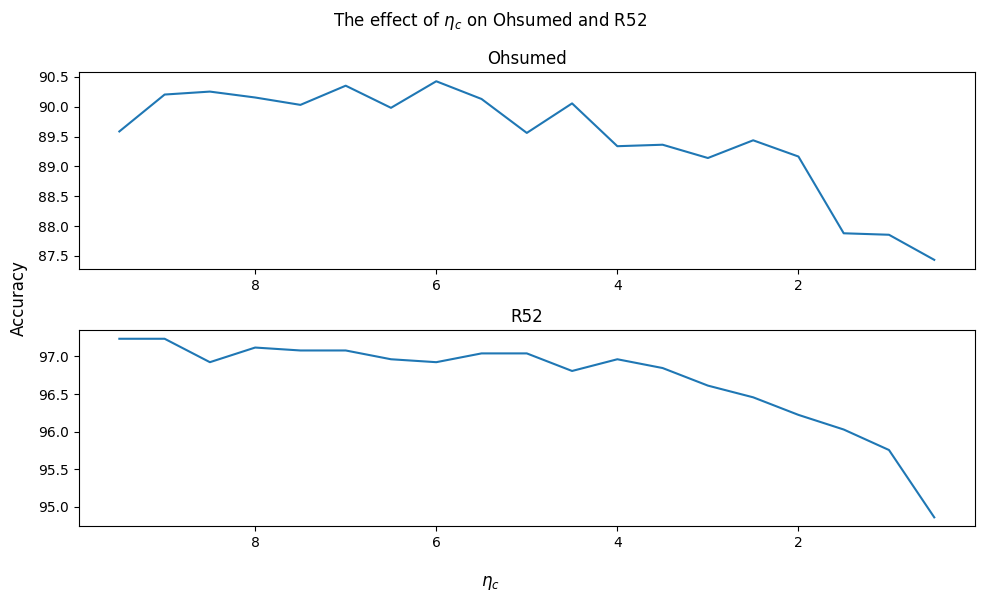

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
fig : Figure 
axs : np.ndarray[Axes]
for i, ax in enumerate(axs.flat):
    ax : Axes
    
    if i < 2:
        ax.set_title(good_keys[i])
        ax.invert_xaxis()
        ax.plot(eta_cs[1:], w_results[good_keys[i]]['BEST_ACC'][1:])
    else:
        ax.set_visible(False)
fig.set_alpha(0.0)
fig.supxlabel('$\\eta_{c}$')
fig.supylabel('Accuracy')   
fig.suptitle(t = "The effect of $\\eta_{c}$ on Ohsumed and R52")
fig.tight_layout()
# fig.savefig('./result/good_eta_c_effect_to_01.svg', transparent=True, format = 'svg')
plt.show()

In [28]:
bad_keys = ["20NewsGroup", "MR", "R8"]

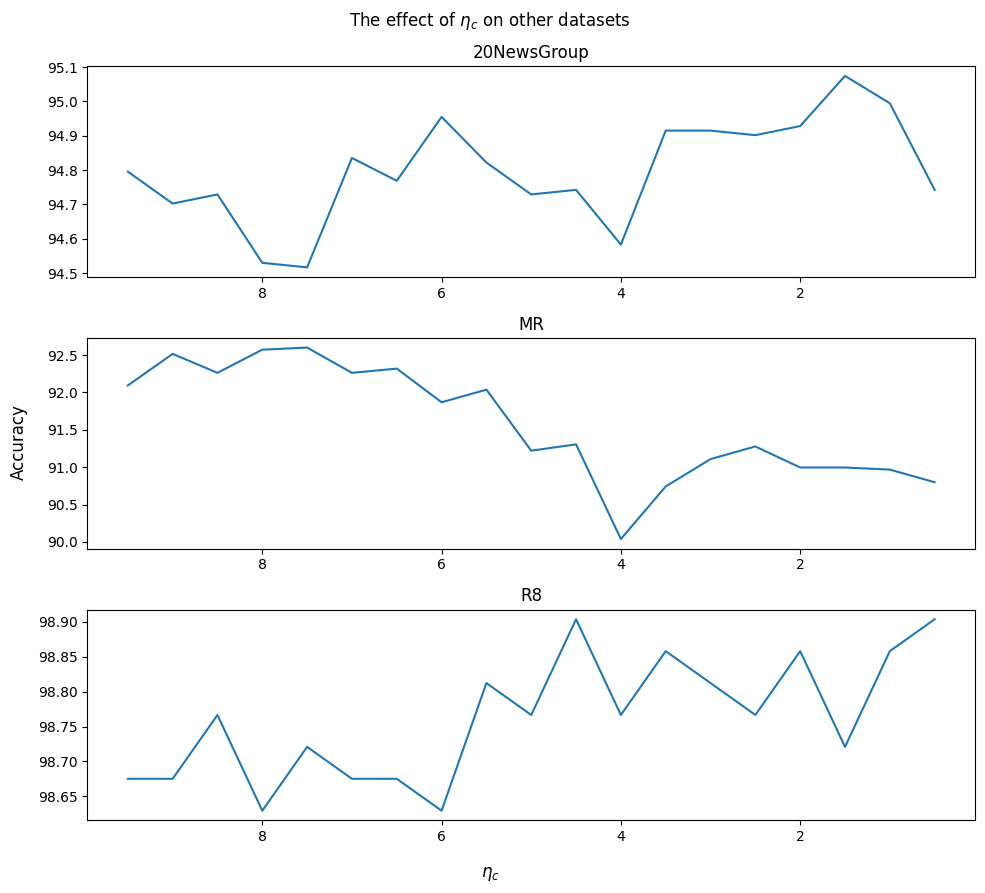

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
fig : Figure 
axs : np.ndarray[Axes]
for i, ax in enumerate(axs.flat):
    ax : Axes
    
    if i < 3:
        ax.set_title(bad_keys[i])
        ax.invert_xaxis()
        ax.plot(eta_cs[1:], w_results[bad_keys[i]]['BEST_ACC'][1:])
    else:
        ax.set_visible(False)
fig.set_alpha(0.0)
fig.supxlabel('$\\eta_{c}$')
fig.supylabel('Accuracy')   
fig.suptitle(t = "The effect of $\\eta_{c}$ on other datasets")
fig.tight_layout()
# fig.savefig('./result/bad_eta_c_effect_to_01.svg', transparent=True, format = 'svg')
plt.show()

In [30]:
# with open(SAVE_PATH, 'wb') as f:
#     pickle.dump(w_results, f)

In [31]:
processed_data = {}
processed_data['eta_c'] = eta_cs[2:]
for key, data in w_results.items():
    processed_data[key] = data['BEST_ACC'][2:]

In [32]:
df = pd.DataFrame(processed_data)

In [33]:
df = df.reindex(columns=['eta_c','MR', 'R8', 'R52', 'Ohsumed', '20NewsGroup'])
df = df.rename(columns={"20NewsGroup" : "20NG"})

In [34]:
df.to_csv('./result/eta_c_gt_1.csv', index=False)